## Model 2: With 3 combinations 

In [7]:
import pandas as pd 

dataset_combined_MF = pd.read_csv("../datasets/combined_3_dataset.csv")
dataset_combined_MF.head() 

C:\Users\melih.kacaman\AppData\Local\Temp\ipykernel_6280\3583458614.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_combined_MF = pd.read_csv("../datasets/combined_3_dataset.csv")


,Unnamed: 0,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
0,0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494,0,4244
1,1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574,1,3410
2,2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358,2,2753
3,3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574,3,3410
4,4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328,4,2489


In [50]:
np.mean(np.power(np.e, dataset_combined_MF[dataset_combined_MF.option_count == 2].rating))

5.420824837637819

In [8]:
len(dataset_combined_MF["RHS_C"].unique()), len(dataset_combined_MF["LHS_C"].unique())

(4898, 111164)

In [95]:
from tensorflow import keras 

n_rhs, n_lhs = len(dataset_combined_MF.RHS_C.unique()), len(dataset_combined_MF.LHS_C.unique())
n_latent_factors = 20
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 
model_2 = keras.Model([lhs_input, rhs_input], product) 

model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [96]:
initial_weights_model_2 = model_2.get_weights() 

In [10]:
from sklearn.model_selection import train_test_split 
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(dataset_combined_MF[["RHS_C", "LHS_C"]], dataset_combined_MF.rating, test_size=0.10, random_state=42) 
X_train_3[:5], y_train_3[:5]

(        RHS_C  LHS_C
 411499   4068  89108
 101922   3633  27744
 386094    643   9717
 224139   1372  54587
 422762    257  92003,
 411499    1.098612
 101922    0.693147
 386094    0.693147
 224139    0.693147
 422762    0.693147
 Name: rating, dtype: float64)

In [11]:
cp_callback = keras.callbacks.ModelCheckpoint(filepath="../checkpoints/model_2.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
import numpy as np

# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=6)
# history = model_2.fit(
#     [X_train_3.LHS_C, X_train_3.RHS_C], 
#     np.array(y_train_3, dtype=float),
#     validation_data=([X_test_3.LHS_C, X_test_3.RHS_C], np.array(y_test_3, dtype=float)),
#     epochs=100, 
#     callbacks=[early_stopping, cp_callback]
# )

In [15]:
import tensorflow as tf 
latest = tf.train.latest_checkpoint("../checkpoints")
latest 

'../checkpoints\\model_2.ckpt'

In [16]:
model_2.load_weights(latest) 

In [ ]:
from matplotlib import pyplot as plt 
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

In [18]:
lhs_embddings_3 = model_2.get_layer(name='lhs-embeddings').get_weights()[0]
rhs_embddings_3 = model_2.get_layer(name='rhs-embeddings').get_weights()[0]

In [19]:
def recommend3(option_in_category, number_of_options=5):
  options = lhs_embddings_3[option_in_category]@rhs_embddings_3.T
  mids = np.argpartition(options, -number_of_options)[-number_of_options:]
  
  return mids

In [68]:
dataset_combined_MF[dataset_combined_MF.LHS == 753600]

,Unnamed: 0,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
524302,524302,2.772589,"(753600, 705592)",2,753600,705592,106404,1515
524314,524314,3.091042,"(753600, 723441)",2,753600,723441,106404,2189
524422,524422,3.784190,"(753600, 614691)",2,753600,614691,106404,150
525351,525351,1.945910,"(753600, 757080)",2,753600,757080,106404,3582
525352,525352,3.044522,"(753600, 757092)",2,753600,757092,106404,3587
...,...,...,...,...,...,...,...,...
686562,686562,0.693147,"(753600, 773655)",2,753600,773655,106404,4316
688233,688233,1.386294,"(753600, 571962)",2,753600,571962,106404,21
690033,690033,0.693147,"(753600, 678091)",2,753600,678091,106404,975
694044,694044,0.693147,"(753600, 695820)",2,753600,695820,106404,1333


In [75]:
min(dataset_combined_MF.rating)

0.6931471805599453

In [84]:
recommend3(107516)

array([4745,  425, 1481,  164, 3217], dtype=int64)

In [83]:
# (614684,614718 )
dataset_combined_MF[dataset_combined_MF.LHS == 614684]

,Unnamed: 0,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
526219,526219,2.639057,"(614684, 663302)",2,614684,663302,107516,498
526220,526220,0.693147,"(614684, 761919)",2,614684,761919,107516,3826
527336,527336,4.248495,"(614684, 614718)",2,614684,614718,107516,164
530857,530857,1.386294,"(614684, 668190)",2,614684,668190,107516,631
531044,531044,1.386294,"(614684, 671998)",2,614684,671998,107516,797
...,...,...,...,...,...,...,...,...
683911,683911,0.693147,"(614684, 684838)",2,614684,684838,107516,1085
688695,688695,0.693147,"(614684, 750108)",2,614684,750108,107516,2824
690189,690189,1.098612,"(614684, 751526)",2,614684,751526,107516,2904
691150,691150,0.693147,"(614684, 669375)",2,614684,669375,107516,694


# Evaluation 
### Best Seller Options 
Option  bill <br>
753600	9640 <br>
795363	6915 <br>
525100	6693 <br>
753609	6457 <br>
778914	6290 <br>
753517	6178 <br>
751581	5473

In [20]:
best_seller = [753600,795363,525100,753609,778914,753517,751581]

In [21]:
bills_contained_best_seller = list(filter(lambda t: any([str(item) in str(t) for item in best_seller]), dataset_combined_MF.bill))
bills_contained_best_seller[:10]

['(753600, 744129, 744133)',
 '(753600, 744129, 744133)',
 '(753600, 744129, 744133)',
 '(753600, 744129, 753455)',
 '(753600, 744129, 753455)',
 '(753600, 744129, 753455)',
 '(753600, 744129, 751578)',
 '(753600, 744129, 751578)',
 '(753600, 744129, 751578)',
 '(753600, 744129, 772478)']

In [87]:
lhs_sample = dataset_combined_MF[dataset_combined_MF.LHS == 614684].LHS_C.iat[0]

In [88]:
rhs_sample = dataset_combined_MF[dataset_combined_MF.RHS == 614718].RHS_C.iat[0]

In [89]:
x_predicted = lhs_embddings_3[lhs_sample]@rhs_embddings_3[rhs_sample].T
x_predicted

2.8654513

In [91]:
np.mean(dataset_combined_MF.rating)

0.9872827350130099

In [90]:
np.power(np.e, x_predicted)

17.556975510107353

In [26]:
max(dataset_combined_MF.rating)

7.720905251936779

In [40]:
np.power(np.e, np.median(dataset_combined_MF.rating))

1.9999999999999998

In [41]:
np.median(dataset_combined_MF.rating)

0.6931471805599453

In [43]:
np.mean(np.power(np.e, dataset_combined_MF.rating))

3.5707389538756544

### Get all best sellers 

In [27]:
query = "select top 100 SidSecenek, count(distinct Sira) cnt from Proto.ilknur.BirliktelikAnaliziMrkScnkDty where SidMalzemeMarka = 4 and SidMalzemeCinsiyet = 3 and SidMalzemeUrunGrubu not in (10,21, 23, 25, 32, 41, 46, 128, 237) group by SidSecenek order by 2 desc"

In [29]:
# from helpers import close_connection, open_connection, custom_query 
# conn = open_connection() 
# data_best_100 = pd.read_sql(query, conn)
# close_connection(conn) 

c:\Users\melih.kacaman\Anaconda3\envs\MF_project\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [30]:
data_best_100 = data_best_100.SidSecenek.to_numpy()
data_best_100[:10] 

array([753600, 753517, 753350, 753376, 753609, 751600, 753509, 789153,
       789122, 751581], dtype=int64)

In [31]:
from helpers import findsubsets 

subsets_best_100 = findsubsets(data_best_100, 2)
subsets_best_100[:5]

[(753600, 753517),
 (753600, 753350),
 (753600, 753376),
 (753600, 753609),
 (753600, 751600)]

In [32]:
subsets_best_100 = [str(item) for item in subsets_best_100]

In [33]:
pd.DataFrame({"bill": subsets_best_100})

,bill
0,"(753600, 753517)"
1,"(753600, 753350)"
2,"(753600, 753376)"
3,"(753600, 753609)"
4,"(753600, 751600)"
...,...
4945,"(748951, 759397)"
4946,"(748951, 752245)"
4947,"(752244, 759397)"
4948,"(752244, 752245)"


In [34]:
q = pd.merge(dataset_combined_MF[dataset_combined_MF.option_count == 2]["bill"].to_frame(), pd.DataFrame({"bill": subsets_best_100}), on="bill", how="right",
        indicator=True)
q[q._merge == "right_only"]

,bill,_merge
9,"(753600, 760677)",right_only
12,"(753600, 762033)",right_only
14,"(753600, 767733)",right_only
19,"(753600, 748903)",right_only
29,"(753600, 761915)",right_only
...,...,...
4938,"(750057, 759397)",right_only
4942,"(750054, 759397)",right_only
4945,"(748951, 759397)",right_only
4947,"(752244, 759397)",right_only


In [63]:
# 	(753517, 753509)	
lhs_sample = dataset_combined_MF[dataset_combined_MF.LHS == 753517].LHS_C.iat[0]
rhs_sample = dataset_combined_MF[dataset_combined_MF.RHS == 753509].RHS_C.iat[0]
x_predicted = lhs_embddings_3[lhs_sample]@rhs_embddings_3[rhs_sample].T
x_predicted

3.12425

In [64]:
np.power(np.e, x_predicted)

22.74283009695782

# Model 3: With 3 Combination on USPA Women 

In [115]:
women_data = pd.read_csv("../datasets/ratings_with_3_combinations_reduced_women_cluster.csv") 
women_data.head() 

C:\Users\melih.kacaman\AppData\Local\Temp\ipykernel_6280\2464364806.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  women_data = pd.read_csv("../datasets/ratings_with_3_combinations_reduced_women_cluster.csv")


,Unnamed: 0,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
0,0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494,0,4244
1,1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574,1,3410
2,2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358,2,2753
3,3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574,3,3410
4,4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328,4,2489


In [116]:
women_data.drop(women_data.columns[[0]], axis=1, inplace=True)

In [117]:
women_data.head() 

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494,0,4244
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574,1,3410
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358,2,2753
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574,3,3410
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328,4,2489


## Model 3: Creation 

In [118]:
from tensorflow import keras 

n_rhs, n_lhs = len(women_data.RHS_C.unique()), len(women_data.LHS_C.unique())
n_latent_factors = 10
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 
model_3_women = keras.Model([lhs_input, rhs_input], product) 

model_3_women.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [126]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(women_data[["RHS_C", "LHS_C"]], women_data.rating, test_size=0.20, random_state=42) 

In [127]:
cp_callback = keras.callbacks.ModelCheckpoint(filepath="../checkpoints/model_3.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=5)
history = model_3_women.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    np.array(y_train, dtype=float),
    validation_data=([X_test.LHS_C, X_test.RHS_C], np.array(y_test, dtype=float)),
    epochs=100, 
    callbacks=[early_stopping, cp_callback]
)

Epoch 1/100
17938/17940 [============================>.] - ETA: 0s - loss: 0.6497 - mae: 0.6431 - mse: 0.6497
Epoch 1: saving model to ../checkpoints\model_3.ckpt
17940/17940 [==============================] - 185s 10ms/step - loss: 0.6497 - mae: 0.6431 - mse: 0.6497 - val_loss: 0.3193 - val_mae: 0.4304 - val_mse: 0.3193
Epoch 2/100
17937/17940 [============================>.] - ETA: 0s - loss: 0.2496 - mae: 0.3654 - mse: 0.2496
Epoch 2: saving model to ../checkpoints\model_3.ckpt
17940/17940 [==============================] - 194s 11ms/step - loss: 0.2496 - mae: 0.3654 - mse: 0.2496 - val_loss: 0.2583 - val_mae: 0.3736 - val_mse: 0.2583
Epoch 3/100
17940/17940 [==============================] - ETA: 0s - loss: 0.1995 - mae: 0.3142 - mse: 0.1995
Epoch 3: saving model to ../checkpoints\model_3.ckpt
17940/17940 [==============================] - 211s 12ms/step - loss: 0.1995 - mae: 0.3142 - mse: 0.1995 - val_loss: 0.2398 - val_mae: 0.3551 - val_mse: 0.2398
Epoch 4/100
17940/17940 [======

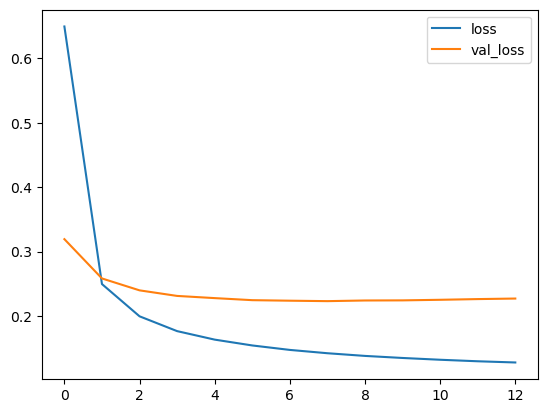

In [142]:
import matplotlib.pyplot as plt 

pd.DataFrame(history.history)[["loss", "val_loss"]].plot() 
plt.show() 